## Problem Statement

**Problem:** Accurately predicting loan approvals is essential for banks to ensure operational efficiency, reduce default risks, and enhance customer satisfaction. Despite access to diverse applicant data, the bank lacks a well-optimized predictive model capable of delivering highly accurate and reliable loan approval outcomes. Additionally, some loan approval decisions may be influenced by individual biases of decision-makers, leading to inconsistencies and potential unfairness.
To address this, the bank plans to utilize historical loan approval data to develop a predictive regression model. This model will predict loan approval decisions based on overall trends and key factors, reducing the influence of individual biases and ensuring fair, data-driven decision-making.

**Task:** To identify and implement the most effective predictive model, to streamline loan approval processes and improve accuracy, consistency, and fairness.

**Data Source:** https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset

## Import Libraries

In [96]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score, log_loss
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

In [97]:
from sklearn import set_config
set_config(transform_output="pandas")

In [98]:
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.tree import plot_tree
import shap

In [99]:
import sys
sys.path.append('../src') 

from custom_preprocess import NewFeaturesCreator, NegativeDataCleaner

## Load/Prepare Data

In [100]:
raw_train_data = pd.read_csv('../data/raw_train_df.csv', index_col=0)
raw_test_data = pd.read_csv('../data/raw_test_df.csv', index_col=0)

In [101]:
for data in [raw_train_data, raw_test_data]:
    data.columns = data.columns.str.strip().str.lower().str.replace(" ", "_")

In [102]:
raw_X = raw_train_data.drop('loan_status', axis=1)
y = raw_train_data['loan_status']

In [103]:
categorical_pipeline = Pipeline([
    ('encode', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')),
   ])

numeric_pipeline = Pipeline([
    ('clean_negatives', NegativeDataCleaner()), 
    ('scaler', MinMaxScaler()),
   ])

num_cat_preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, selector(dtype_include=['number', 'float'])),
    ('cat', categorical_pipeline, selector(dtype_include=['object', 'category'])),
], remainder='passthrough').set_output(transform='pandas')  


preprocessing_pipeline = Pipeline([
    ('create_features', NewFeaturesCreator()),
    ('num_cat_preprocessor', num_cat_preprocessor),  
    ])

In [104]:
X = preprocessing_pipeline.fit_transform(raw_X)

C:\Users\Татьяна\Desktop\GitHub\Data-Analysis\Loan_Approval_Forecast\notebooks\../src\custom_preprocess.py:27: UserWarning: Negative values detected in 'residential_assets_value'. They will be replaced with the column median.
  warnings.warn(f"Negative values detected in '{col}'. They will be replaced with the column median.", UserWarning)


In [105]:
X.head()

,num__no_of_dependents,num__income_annum,num__loan_amount,num__loan_term,num__cibil_score,num__residential_assets_value,num__commercial_assets_value,num__luxury_assets_value,num__bank_asset_value,num__all_assets,num__income_per_person,num__debt_income_ratio,num__debt_assets_ratio,num__amount_term_ratio,cat__education_ Not Graduate,cat__self_employed_ Yes
loan_id,,,,,,,,,,,,,,,,
2897,0.4,0.536082,0.436224,0.444444,0.058333,0.202749,0.072165,0.457584,0.292517,0.309202,0.179054,0.688890,0.215153,0.122282,0.0,0.0
4235,0.6,0.134021,0.122449,0.666667,0.895000,0.140893,0.051546,0.077121,0.095238,0.100613,0.034628,0.760000,0.181468,0.025409,1.0,1.0
3252,0.8,0.103093,0.076531,0.000000,0.440000,0.075601,0.025773,0.113111,0.074830,0.088344,0.020946,0.500001,0.111761,0.084695,0.0,0.0
1409,0.6,0.185567,0.099490,0.777778,0.451667,0.058419,0.201031,0.141388,0.088435,0.137423,0.047297,0.240002,0.078237,0.018158,1.0,1.0
1169,0.4,0.896907,0.719388,0.222222,0.111667,0.762887,0.855670,0.544987,0.632653,0.737423,0.297297,0.680900,0.123303,0.316493,0.0,0.0


## Train Models

As observed during the EDA, the dataset exhibits a slight class imbalance. To address this, I will use Stratified K-Fold cross-validation to preserve class distribution across folds and set the class weight to 'balanced' in models that support it. Additionally, since we identified high multicollinearity among features, I’ll apply L1 or L2 regularization in logistic regression to mitigate its impact. For tree-based models, multicollinearity is not a concern, as they are inherently robust to correlated features.

In [106]:
num_positive = (y == 1).sum()
num_negative = (y == 0).sum()
scale_pos_weight = num_negative / num_positive

In [107]:
base_models = {'lr':  LogisticRegression(penalty='elasticnet', C=1.0, solver='saga', l1_ratio=0.5),
               'lgbm': LGBMClassifier( random_state=42, class_weight='balanced',   verbose=-1),
               'xgb': XGBClassifier(random_state=42, verbosity=0, use_label_encoder=False, scale_pos_weight=scale_pos_weight),
               'cat': CatBoostClassifier(random_state=42, verbose=0, auto_class_weights='Balanced'),
               'rf': RandomForestClassifier(random_state=42, class_weight='balanced', verbose=0)}

In [108]:
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

In [109]:
def find_metrics(y_true, y_pred, model_name=None) -> dict:
    metrics_dict = {
        'classifier': model_name,
        'accuracy_score': accuracy_score(y_true, y_pred),
        'precision_score': precision_score(y_true, y_pred),
        'recall_score': recall_score(y_true, y_pred), 
        'f1_score': f1_score(y_true, y_pred),
        'log_loss': log_loss(y_true, y_pred)
    }
    return metrics_dict

In [110]:
oof = {name: np.zeros(len(X)) for name in base_models}
results = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    for m_name, model in base_models.items():
        model.fit(X_train, y_train)
        pred_proba = model.predict_proba(X_val)[:,1]
        preds = (pred_proba > 0.5).astype(int)
        oof[f"{m_name}"][val_idx] = pred_proba
        
        results.append(find_metrics(y_val, preds, model_name=m_name))

In [111]:
results_df = pd.DataFrame(results)
mean_results = results_df.groupby('classifier').agg('mean')

In [112]:
def style_results_table(df):
    styled = (
        df.style
        .set_sticky().set_table_attributes("style='width:100%'")
        .format({'f1_score': '{:.4f}', 'log_loss': '{:.4f}'})
        .bar(subset=['f1_score'], color='rgba(141, 93, 148, 0.6)', vmin=0.965, vmax=df['f1_score'].max())
        .bar(subset=['log_loss'], color='rgba(106, 95, 148, 0.6)', vmin=0, vmax=df['log_loss'].max())
        .set_caption("Model Performance")
        .set_properties(**{'text-align': 'center'})
        .set_table_styles([
            {"selector": "th", "props": [("text-align", "center")]},
            {"selector": "caption", "props": [("caption-side", "top"), ("font-weight", "bold")]}
        ])
    )
    return styled

style_results_table(mean_results.sort_values(['log_loss', 'accuracy_score']))

,accuracy_score,precision_score,recall_score,f1_score,log_loss
classifier,,,,,
rf,0.995867,0.994295,0.999114,0.9967,0.1490
lgbm,0.994764,0.996033,0.995572,0.9958,0.1887
xgb,0.994489,0.996023,0.995131,0.9956,0.1986
cat,0.994213,0.995143,0.995573,0.9954,0.2086
lr,0.925579,0.938010,0.942847,0.9404,2.6824


- Given the business context, where both false approvals and false rejections carry significant costs, I prioritize models that maintain a good balance between precision and recall, with a strong emphasis on the F1 score.

- All tree-based models performed exceptionally well across all metrics, with Random Forest achieving the highest F1 score (0.9966) and the lowest log loss (0.1520), indicating both accurate classification and well-calibrated probability estimates. CatBoost followed closely, offering a similarly strong balance.

- Logistic Regression, while offering reasonable precision and recall, significantly underperformed in terms of log loss (2.6764), indicating poorly calibrated predicted probabilities and reduced reliability for decision-making in this context. This outcome is expected, as the model used default hyperparameters without any tuning or calibration applied. Further optimization, such as regularization tuning or probability calibration, may improve its performance.

- Given the goal of reliably distinguishing between loan approvals and rejections with minimal misclassification risk, Random Forest and CatBoost emerge as the most suitable candidates, providing robust and balanced performance. These models are particularly well-suited to this domain, where both types of classification errors (false approvals and false rejections) must be minimized.

## Final model

In [113]:
# Run new regression
rf_final = RandomForestClassifier(random_state=42, class_weight='balanced', verbose=0)
rf_final.fit(X, y)
X_test = preprocessing_pipeline.transform(raw_test_data.drop('loan_status', axis=1))
test_preds = rf_final.predict(X_test)

C:\Users\Татьяна\Desktop\GitHub\Data-Analysis\Loan_Approval_Forecast\notebooks\../src\custom_preprocess.py:27: UserWarning: Negative values detected in 'residential_assets_value'. They will be replaced with the column median.
  warnings.warn(f"Negative values detected in '{col}'. They will be replaced with the column median.", UserWarning)


In [114]:
y_true_test = raw_test_data['loan_status']

In [115]:
test_metrics = find_metrics(y_true_test, test_preds, model_name='rf')
print(test_metrics)

{'classifier': 'rf', 'accuracy_score': 0.9953198127925117, 'precision_score': 0.9925373134328358, 'recall_score': 1.0, 'f1_score': 0.9962546816479401, 'log_loss': 0.1686910455028886}


## Understanding Model Decision-Making

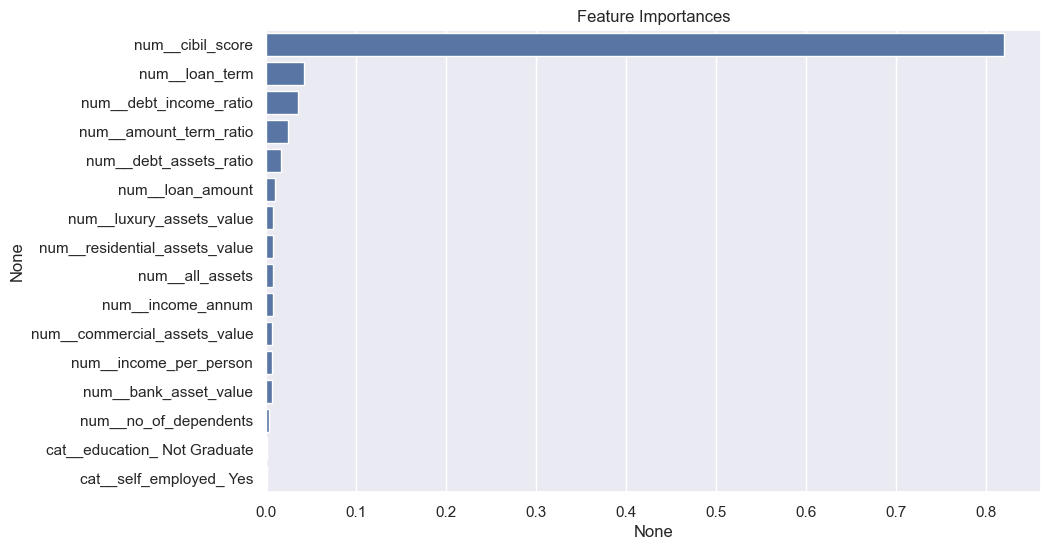

In [116]:
importances = rf_final.feature_importances_
feat_importances = pd.Series(importances, index=X_train.columns)
feat_importances = feat_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances, y=feat_importances.index)
plt.title("Feature Importances")
plt.show()

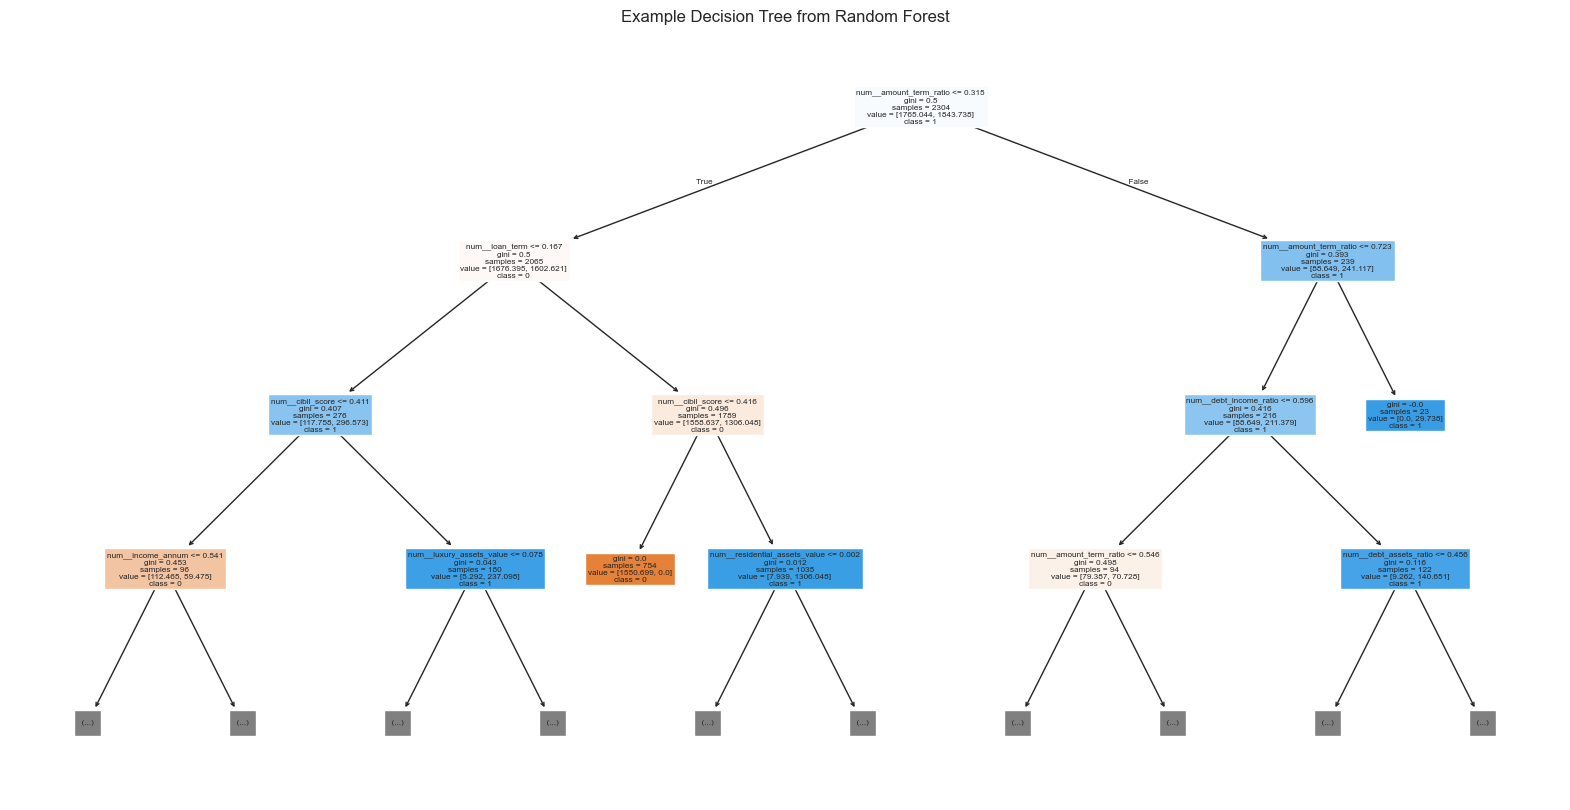

In [117]:
plt.figure(figsize=(20, 10))
plot_tree(rf_final.estimators_[2], 
          feature_names=X_test.columns, 
          class_names=[str(c) for c in rf_final.classes_], 
          filled=True, 
          max_depth=3)
plt.title("Example Decision Tree from Random Forest")
plt.show()

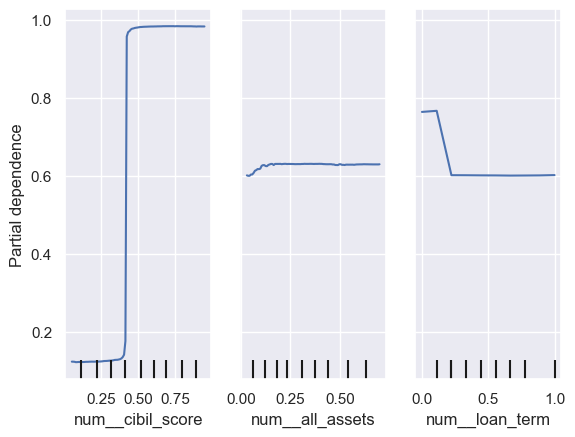

In [118]:
features =['num__cibil_score', 'num__all_assets', 'num__loan_term']  
PartialDependenceDisplay.from_estimator(rf_final, X_test, features, kind="average")
plt.show()

As expected, the cibil_ratio plays a major role in the model's decision-making process.

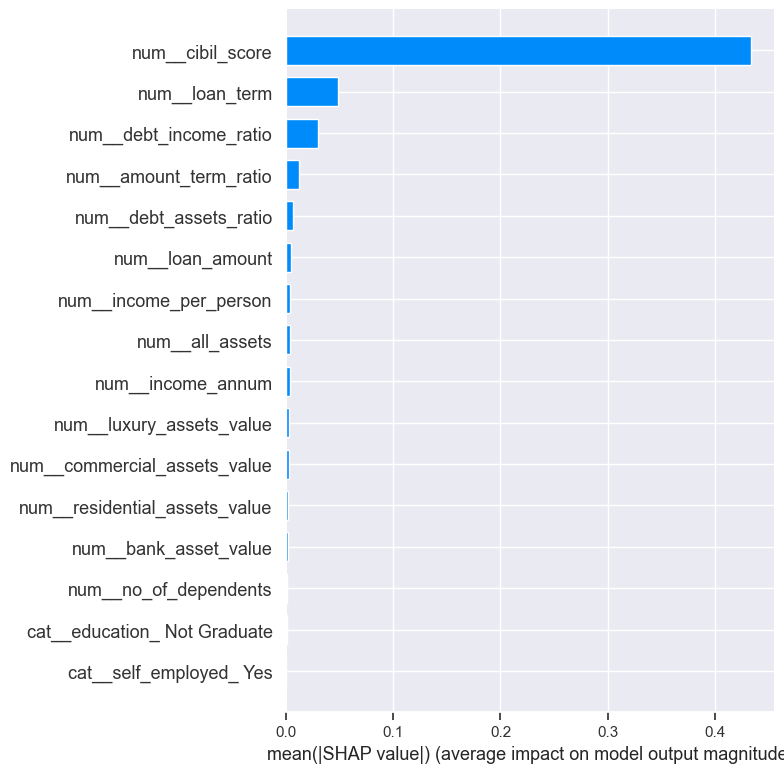

In [119]:
explainer = shap.TreeExplainer(rf_final)
shap_values = explainer.shap_values(X_test)

# Select SHAP values for class 1
shap_values_class1 = shap_values[:, :, 1]
shap_values_class0 = shap_values[:, :, 0]

shap.summary_plot(shap_values_class1, X_test, plot_type="bar")

C:\Users\Татьяна\Desktop\GitHub\Data-Analysis\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


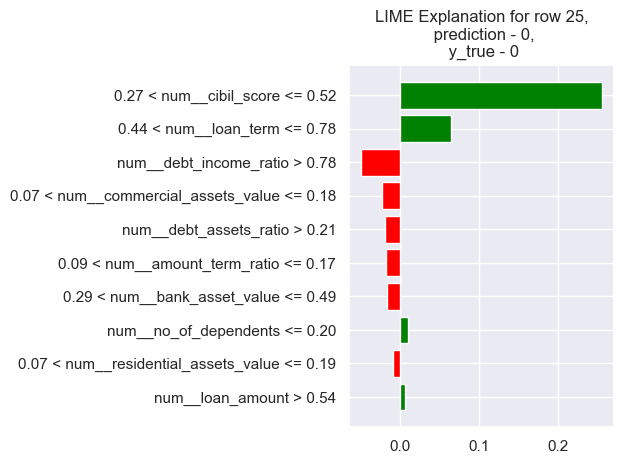

In [120]:
row_num = 25

explainer = LimeTabularExplainer(
    training_data=X_test.values if hasattr(X_test, "values") else X_test,
    feature_names=X_test.columns.tolist() if hasattr(X_test, "columns") else [f'feature_{i}' for i in range(X_test.shape[1])],
    class_names=rf_final.classes_.tolist(),
    mode='classification'
)

instance = X_test.iloc[row_num].values
exp = explainer.explain_instance(instance, rf_final.predict_proba, top_labels=1)

try:
    class_idx = exp.top_labels[0]
    fig = exp.as_pyplot_figure(label=class_idx)
    plt.title(f"LIME Explanation for row {row_num},\n prediction - {class_idx},\n y_true - {y_true_test.iloc[row_num]}")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Plotting failed:", e)

## Save the model

In [121]:
import pickle

In [122]:
with open ('../models/rf_model', 'wb') as file:
    pickle.dump(rf_final, file)